# 0. Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import random

import joblib
import lightgbm as lgbm
import numpy as np
import pandas as pd
import shap
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

import matplotlib.pyplot as plt

random.seed(0)

# 1. Introduction

In order to find out if the machine learning model correctly learned the effect of each extrusion parameter on the throughput, the feature importances of a machine learning model were investigated by using `shap` library. Just to save the computation time, the optimized `LightGBM` model (whose optimization process is shown in Appendix 2) was used to check the feature importances.

# 2. Preparation of model and data

In [2]:
model = joblib.load("../models/optimized_lgbm_model.pkl")

In [3]:
df = pd.read_csv("../data/dataset_generated_by_extrucal.csv")

In [4]:
# Apply log-transformation to target
df["log_throughput"] = np.log1p(df["throughput"])

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [6]:
X_test = test_df.drop(columns=["throughput", "log_throughput"])
y_test = test_df["log_throughput"]

In [7]:
X_test_enc = model.named_steps["columntransformer"].transform(X_test)

In [8]:
columns = (
    model.named_steps["columntransformer"]
    .named_transformers_["pipeline-1"]
    .named_steps["standardscaler"]
    .get_feature_names_out()
    .tolist()
    + model.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["standardscaler"]
    .get_feature_names_out()
    .tolist()
)

In [9]:
X_test_enc_df = pd.DataFrame(X_test_enc, columns=columns, index=X_test.index)

# 3. Feature Importance of `LightGBM` Model Using `shap` library

In [10]:
shap.initjs()

In [11]:
lgbm_explainer = shap.Explainer(model.named_steps["lgbmregressor"])

In [12]:
shap_values = lgbm_explainer(X_test_enc_df)

## 3.1. Rank of Features

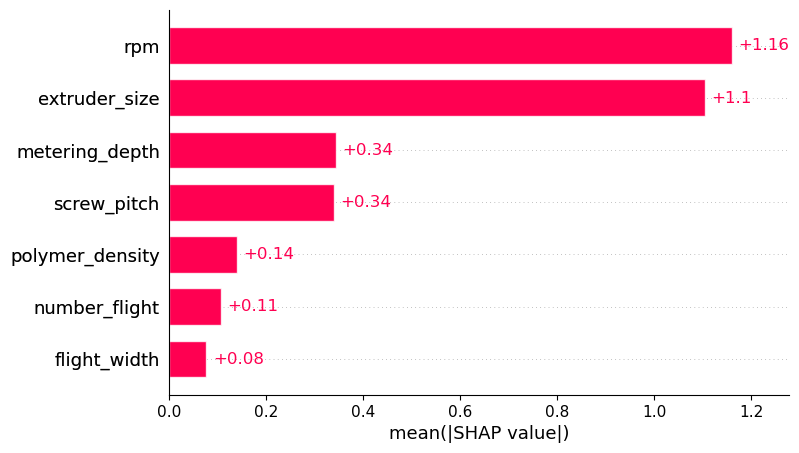

In [13]:
fig = plt.gcf()
shap.plots.bar(shap_values, max_display=20)
fig.savefig('../img/feature_rank.png', bbox_inches='tight')

Similarly to actual extrusion processes, `rpm` and `extruder_size` were two biggest processing parameter for the model. The rank for the rest of the processing parameters also made sense

## 3.2. Effect of Each Processing Parameter on Throughput

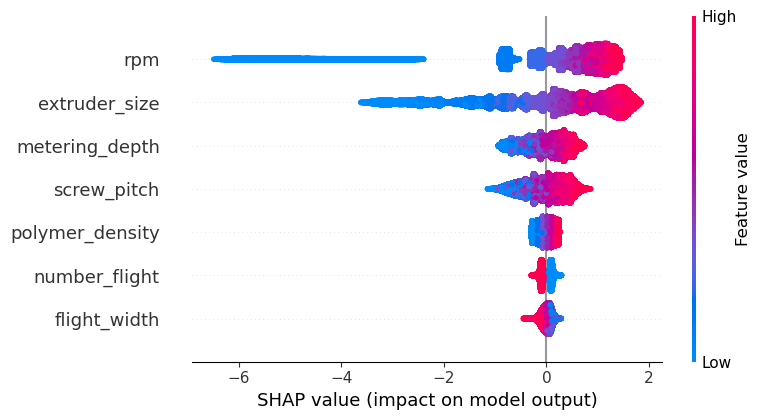

In [14]:
fig = plt.gcf()
shap.summary_plot(shap_values)
fig.savefig('../img/feature_effect.png', bbox_inches='tight')

The effect of each processing parameter on the throughput was correctly displayed. For example, the throughput increased with increasing `rpm`, `extruder_size`, `metering_depth`, `screw_pitch`, and `polymer_density`, whereas it decreased with increasing `number_flight` and `flight_width`.

## 3.3. Influence of Features on Individual Data 

### 3.3.1. Prediction for Small Extruder

In [15]:
test_df.iloc[[0]]

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput,log_throughput
1016053,30,1.8,1100,20,42.0,5.4,2,2.471673,1.244637


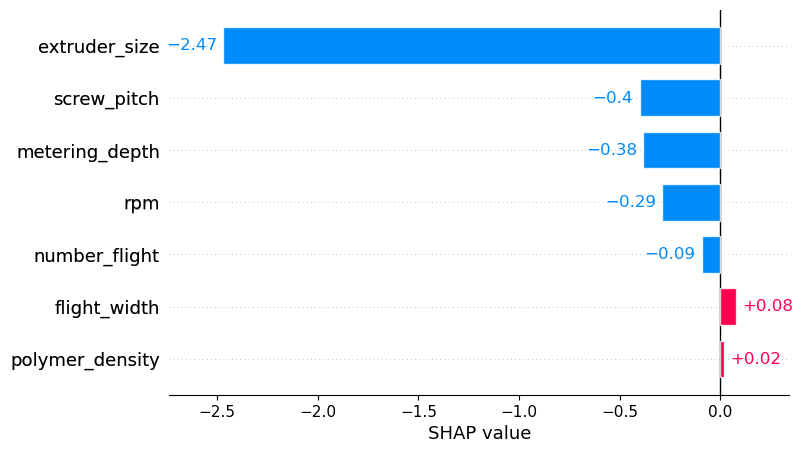

In [16]:
shap.plots.bar(shap_values[0], max_display=20)

The small size of the extruder (i.e. 30 mm) was the strongest feature that decreased the prediction.

### 3.3.2. Prediction for Big Extruder

In [17]:
test_df.iloc[[2]]

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput,log_throughput
679659,230,11.5,1200,20,276.0,36.8,2,922.826511,6.828524


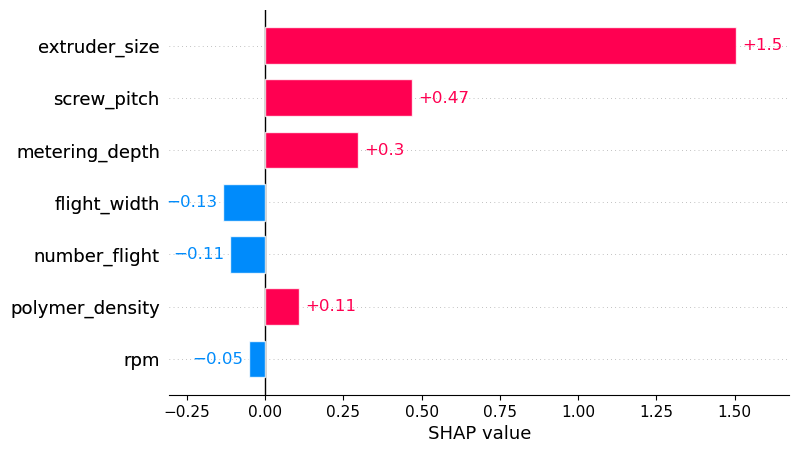

In [18]:
shap.plots.bar(shap_values[2], max_display=20)

Again, `extruder_size` (i.e., 230 mm) played a significant role in the prediction of the throughput.

# 3. Conclusion

The features of the trained model seemed to have similar effects to those of the actual extrusion process parameters.